07.02.23

# Analyse slices annotated by experts

- Open, organise and analyse the slices that have been annotated by the experts.
- Compute some metrics to get inter-observer variability

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
#import glob
import os
import imageio
import napari
import matplotlib.pyplot as plt
import math
import seaborn as sns
import pandas as pd

#from skimage.io import imsave

from in_out_tools import load_movies_ids, load_annotations_ids
from visualization_tools import get_discrete_cmap, get_labels_cmap, get_annotations_contour
from metrics_tools import compute_iou, empty_marginal_frames
from data_processing_tools import get_processed_result, class_to_nb, dict_to_int_mask

## Load slices annotated by experts

In [42]:
#slices_ids = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10']
slices_ids = ['01', '02', '03', '05', '06', '07', '09', '10']

#expert_ids = ['RJ', 'ME', 'NS', 'EN', 'MW', 'MF', 'CS']
expert_ids = ['RJ', 'ME', 'EN', 'NS']

# make expert ids anonymous
anon_ids = {expert_id: 'expert_' + str(i) for i, expert_id in enumerate(expert_ids)}
anon_ids_list = list(anon_ids.values())


dir = r'C:\Users\dotti\OneDrive - Universitaet Bern\inter-rater_variability\annotated_slices'

In [43]:
# Load all .tif files and save them in a dictionary
# Dictionary are indexed by the slice id and the expert id
all_segmentations = dict.fromkeys(anon_ids_list+['ground_truth','unet_preds'])

In [44]:
for expert_id in expert_ids:
    all_segmentations[anon_ids[expert_id]] = dict.fromkeys(slices_ids)
    for slice_id in slices_ids:
        all_segmentations[anon_ids[expert_id]][slice_id] = imageio.volread(os.path.join(dir, 
                                                                      expert_id, 
                                                                      'sample'+slice_id+'.tif'))

## Load corresponding slices in annotated dataset and UNet predictions

In [5]:
slice_to_movie_id = {'01': '15',
                     '02': '20',
                     '03': '34',
                     '04': '05',
                     '05': '10',
                     '06': '25',
                     '07': '32',
                     '08': '34',
                     '09': '40',
                     '10': '45'}

slice_to_frame_id = {'01': 54-1,
                     '02': 445-1,
                     '03': 430-1,
                     '04': 351-1,
                     '05': 410-1,
                     '06': 109-1,
                     '07': 950-1,
                     '08': 894-1,
                     '09': 898-1,
                     '10': 667-1}

### Load annotated dataset

In [6]:
dataset_dir = os.path.join("..", "data", "sparks_dataset")

In [45]:
all_segmentations['ground_truth'] = dict.fromkeys(slices_ids)
for slice_id in slices_ids:
    movie_id = slice_to_movie_id[slice_id]
    frame_id = slice_to_frame_id[slice_id]
    all_segmentations['ground_truth'][slice_id] = np.asarray(imageio.volread(os.path.join(
                                                    dataset_dir,
                                                    (movie_id+'_class_label.tif'))))[frame_id]

### Load predicted segmentation

In [8]:
movie_ids = ["05","10","15","20","25","32","34","40","45"]

In [9]:
training_name = 'TEMP_new_annotated_peaks_physio'
epoch = 100000

preds_dir = os.path.join("trainings_validation", training_name)

In [10]:
### Load movies
xs = load_movies_ids(data_folder=dataset_dir,
                     ids=movie_ids,
                     names_available=True,
                     movie_names="video")

### Load predictions
sparks_filenames = {movie_id: os.path.join(preds_dir, f"{training_name}_{epoch}_{movie_id}_sparks.tif") for movie_id in movie_ids}
puffs_filenames = {movie_id: os.path.join(preds_dir, f"{training_name}_{epoch}_{movie_id}_puffs.tif") for movie_id in movie_ids}
waves_filenames = {movie_id: os.path.join(preds_dir, f"{training_name}_{epoch}_{movie_id}_waves.tif") for movie_id in movie_ids}

sparks = {movie_id: np.asarray(imageio.volread(f)) for movie_id, f in sparks_filenames.items()}
puffs = {movie_id: np.asarray(imageio.volread(f)) for movie_id, f in puffs_filenames.items()}
waves = {movie_id: np.asarray(imageio.volread(f)) for movie_id, f in waves_filenames.items()}

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


In [11]:
# parameters necessary to process predictions

# physiological params (for spark peaks results)
pixel_size = 0.2 # 1 pixel = 0.2 um x 0.2 um
min_dist_xy = round(1.8 / pixel_size) # min distance in space
time_frame = 6.8 # 1 frame = 6.8 ms
min_dist_t = round(20 / time_frame) # min distance in time

# spark instances detection parameters
min_dist_xy = min_dist_xy
min_dist_t = min_dist_t
radius = math.ceil(min_dist_xy / 2)
y, x = np.ogrid[-radius : radius + 1, -radius : radius + 1]
disk = x**2 + y**2 <= radius**2
conn_mask = np.stack([disk] * (min_dist_t), axis=0)

# connectivity for event instances detection
connectivity = 26
sigma = 3

# TODO: use better parameters !!!
pixel_size = 0.2
spark_min_width = 3
spark_min_t = 3
puff_min_t = 5
wave_min_width = round(15 / pixel_size)

# maximal gap between two predicted puffs or waves that belong together
max_gap = 2  # i.e., 2 empty frames

In [12]:
preds_segmentation = {}

for movie_id in movie_ids:
    _, preds, _ = get_processed_result(
            sparks=sparks[movie_id],
            puffs=puffs[movie_id],
            waves=waves[movie_id],
            xs=xs[movie_id],
            conn_mask=conn_mask,
            connectivity=connectivity,
            max_gap=max_gap,
            sigma=sigma,
            wave_min_width=wave_min_width,
            puff_min_t=puff_min_t,
            spark_min_t=spark_min_t,
            spark_min_width=spark_min_width,
        )
    preds_segmentation[movie_id] = dict_to_int_mask(preds)

In [46]:
all_segmentations['unet_preds'] = dict.fromkeys(slices_ids)
for slice_id in slices_ids:
    movie_id = slice_to_movie_id[slice_id]
    frame_id = slice_to_frame_id[slice_id]
    all_segmentations['unet_preds'][slice_id] = preds_segmentation[movie_id][frame_id]

In [47]:
all_segmentations.keys()

dict_keys(['expert_0', 'expert_1', 'expert_2', 'expert_3', 'ground_truth', 'unet_preds'])

In [48]:
for slice_id in slices_ids:
    for annotator in all_segmentations.keys():
        print(f"Slice {slice_id} - {annotator}: {np.unique(all_segmentations[annotator][slice_id])}")

Slice 01 - expert_0: [0 3]
Slice 01 - expert_1: [0 3]
Slice 01 - expert_2: [0 3]
Slice 01 - expert_3: [0 1]
Slice 01 - ground_truth: [0 1 3]
Slice 01 - unet_preds: [0 1 3]
Slice 02 - expert_0: [0 1 3]
Slice 02 - expert_1: [0 1 3]
Slice 02 - expert_2: [0 1 2]
Slice 02 - expert_3: [0 2 3]
Slice 02 - ground_truth: [0 3]
Slice 02 - unet_preds: [0 1]
Slice 03 - expert_0: [0 1]
Slice 03 - expert_1: [0 1 3]
Slice 03 - expert_2: [0 1 3]
Slice 03 - expert_3: [0 1]
Slice 03 - ground_truth: [0 1 2]
Slice 03 - unet_preds: [0 1 3]
Slice 05 - expert_0: [0 3]
Slice 05 - expert_1: [0 3]
Slice 05 - expert_2: [0 2 3]
Slice 05 - expert_3: [0 2]
Slice 05 - ground_truth: [0 1 3]
Slice 05 - unet_preds: [0 1 3]
Slice 06 - expert_0: [0 1]
Slice 06 - expert_1: [0 1]
Slice 06 - expert_2: [0]
Slice 06 - expert_3: [0 3]
Slice 06 - ground_truth: [0 1 3]
Slice 06 - unet_preds: [0 1 3]
Slice 07 - expert_0: [0 1]
Slice 07 - expert_1: [0 1]
Slice 07 - expert_2: [0]
Slice 07 - expert_3: [0]
Slice 07 - ground_truth: [0 

In [15]:
from sklearn.metrics import cohen_kappa_score

In [49]:
# for each slice ID, compute inter-annotator agreement and store results in a dataframe
kappa_list = []
for slice_id in slices_ids:
    for annotator_1 in all_segmentations.keys():
        for annotator_2 in all_segmentations.keys():
            if annotator_1 != annotator_2:
                print(f"A1: {annotator_1} - A2: {annotator_2} - Slice: {slice_id}")
                kappa_list.append({'slice_id': slice_id,
                                'annotator_1': annotator_1,
                                'annotator_2': annotator_2,
                                'kappa': cohen_kappa_score(all_segmentations[annotator_1][slice_id].flatten(), 
                                                           all_segmentations[annotator_2][slice_id].flatten(),
                                                           #labels=[0,1,2,3,4]
                                                           )})

kappa_df = pd.DataFrame(kappa_list)

A1: expert_0 - A2: expert_1 - Slice: 01
A1: expert_0 - A2: expert_2 - Slice: 01
A1: expert_0 - A2: expert_3 - Slice: 01
A1: expert_0 - A2: ground_truth - Slice: 01
A1: expert_0 - A2: unet_preds - Slice: 01
A1: expert_1 - A2: expert_0 - Slice: 01
A1: expert_1 - A2: expert_2 - Slice: 01
A1: expert_1 - A2: expert_3 - Slice: 01
A1: expert_1 - A2: ground_truth - Slice: 01
A1: expert_1 - A2: unet_preds - Slice: 01
A1: expert_2 - A2: expert_0 - Slice: 01
A1: expert_2 - A2: expert_1 - Slice: 01
A1: expert_2 - A2: expert_3 - Slice: 01
A1: expert_2 - A2: ground_truth - Slice: 01
A1: expert_2 - A2: unet_preds - Slice: 01
A1: expert_3 - A2: expert_0 - Slice: 01
A1: expert_3 - A2: expert_1 - Slice: 01
A1: expert_3 - A2: expert_2 - Slice: 01
A1: expert_3 - A2: ground_truth - Slice: 01
A1: expert_3 - A2: unet_preds - Slice: 01
A1: ground_truth - A2: expert_0 - Slice: 01
A1: ground_truth - A2: expert_1 - Slice: 01
A1: ground_truth - A2: expert_2 - Slice: 01
A1: ground_truth - A2: expert_3 - Slice: 01


c:\Users\dotti\.conda\envs\sparks\lib\site-packages\sklearn\metrics\_classification.py:673: RuntimeWarning: invalid value encountered in double_scalars
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
c:\Users\dotti\.conda\envs\sparks\lib\site-packages\sklearn\metrics\_classification.py:673: RuntimeWarning: invalid value encountered in double_scalars
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


A1: unet_preds - A2: expert_2 - Slice: 07
A1: unet_preds - A2: expert_3 - Slice: 07
A1: unet_preds - A2: ground_truth - Slice: 07
A1: expert_0 - A2: expert_1 - Slice: 09
A1: expert_0 - A2: expert_2 - Slice: 09
A1: expert_0 - A2: expert_3 - Slice: 09
A1: expert_0 - A2: ground_truth - Slice: 09
A1: expert_0 - A2: unet_preds - Slice: 09
A1: expert_1 - A2: expert_0 - Slice: 09
A1: expert_1 - A2: expert_2 - Slice: 09
A1: expert_1 - A2: expert_3 - Slice: 09
A1: expert_1 - A2: ground_truth - Slice: 09
A1: expert_1 - A2: unet_preds - Slice: 09
A1: expert_2 - A2: expert_0 - Slice: 09
A1: expert_2 - A2: expert_1 - Slice: 09
A1: expert_2 - A2: expert_3 - Slice: 09
A1: expert_2 - A2: ground_truth - Slice: 09
A1: expert_2 - A2: unet_preds - Slice: 09
A1: expert_3 - A2: expert_0 - Slice: 09
A1: expert_3 - A2: expert_1 - Slice: 09
A1: expert_3 - A2: expert_2 - Slice: 09
A1: expert_3 - A2: ground_truth - Slice: 09
A1: expert_3 - A2: unet_preds - Slice: 09
A1: ground_truth - A2: expert_0 - Slice: 09
A1

In [50]:
kappa_df

,slice_id,annotator_1,annotator_2,kappa
0,01,expert_0,expert_1,0.796058
1,01,expert_0,expert_2,0.253748
2,01,expert_0,expert_3,0.116472
3,01,expert_0,ground_truth,0.527734
4,01,expert_0,unet_preds,0.402044
...,...,...,...,...
235,10,unet_preds,expert_0,0.846492
236,10,unet_preds,expert_1,0.577495
237,10,unet_preds,expert_2,0.854686
238,10,unet_preds,expert_3,0.754455


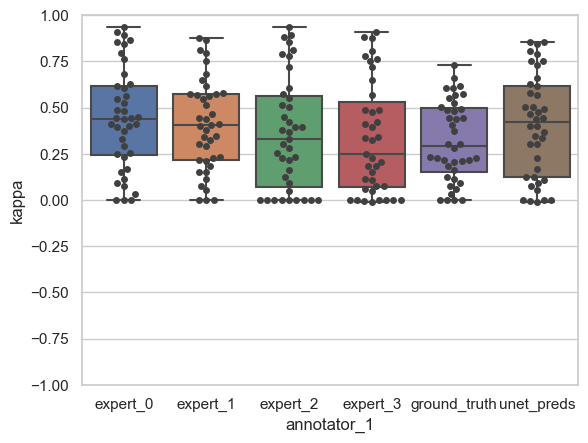

In [51]:
# visualize kappa values
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x="annotator_1", y="kappa", data=kappa_df)
ax = sns.swarmplot(x="annotator_1", y="kappa", data=kappa_df, color=".25")
ax.set_ylim(-1, 1)
plt.show()


(-1.0, 1.0)

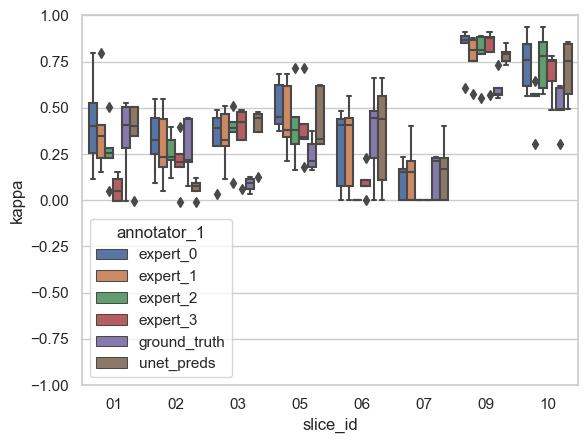

In [52]:
# visualize kappa values for each slice
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x="slice_id", y="kappa", hue="annotator_1", data=kappa_df)
ax.set_ylim(-1, 1)

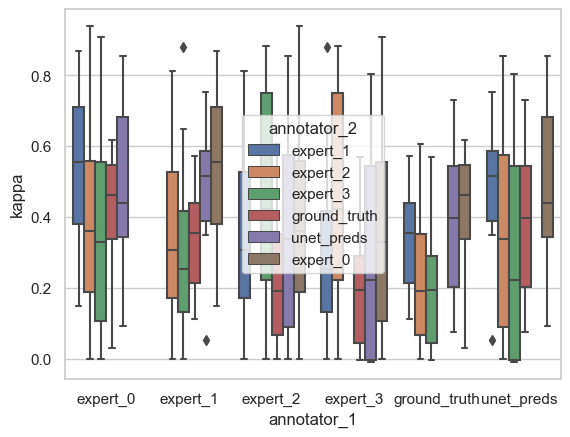

In [53]:
# visualize kappa values for each annotator
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x="annotator_1", y="kappa", hue="annotator_2", data=kappa_df)

[Text(0, 0.5, 'Expert 1'),
 Text(0, 1.5, 'Expert 2'),
 Text(0, 2.5, 'Expert 3'),
 Text(0, 3.5, 'Expert 4'),
 Text(0, 4.5, 'Ground Truth'),
 Text(0, 5.5, 'UNet preds')]

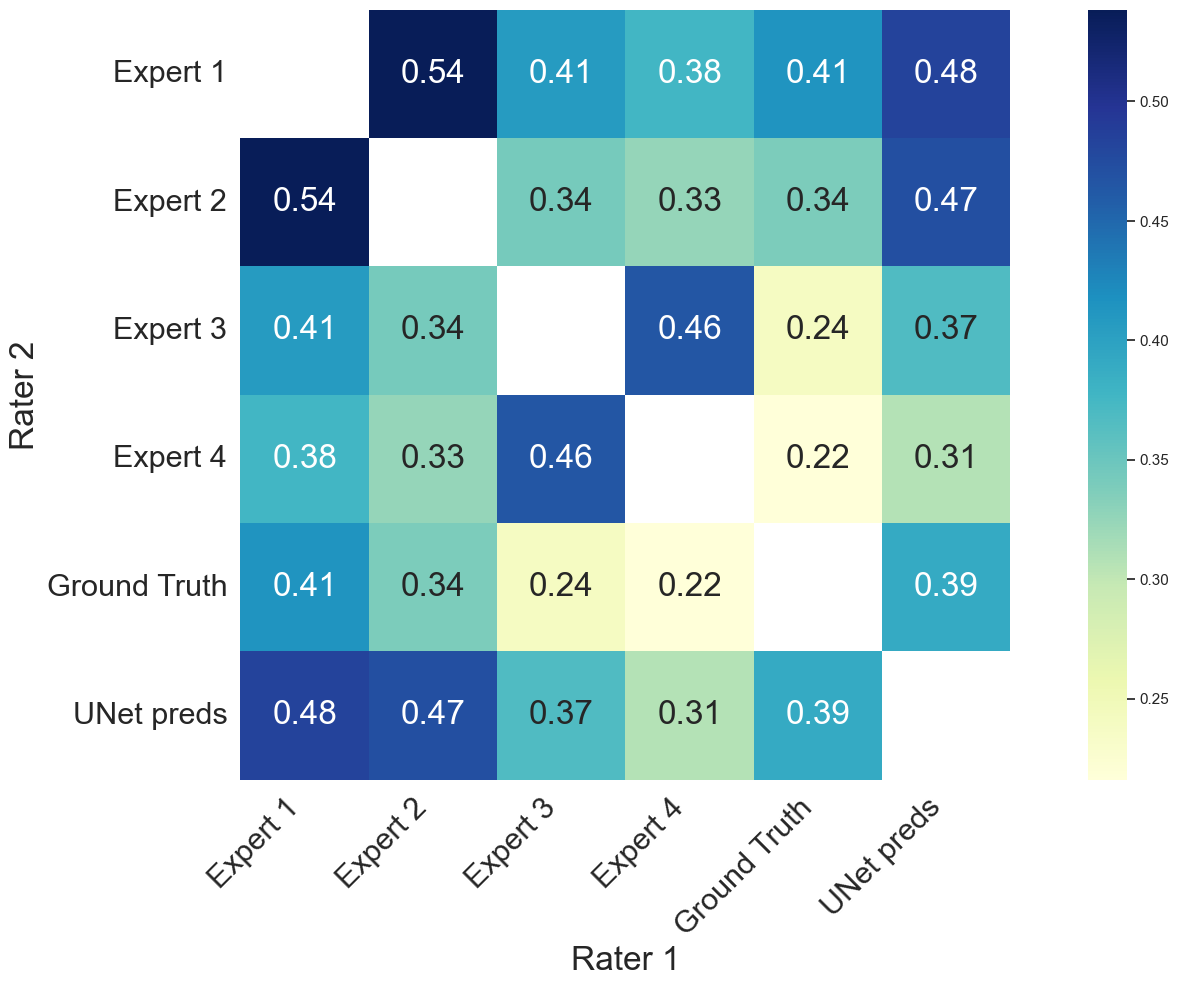

In [54]:
# compute average kappa values over all slices and plot heatmap
avg_kappa_df = kappa_df.pivot_table(index='annotator_1', 
                                    columns='annotator_2', 
                                    values='kappa', 
                                    aggfunc='mean')


plt.figure(figsize = (20,10))

ax = sns.heatmap(avg_kappa_df, annot=True, cmap='YlGnBu', annot_kws={"size": 24}, square=True)
ax.set_xlabel('Rater 1', fontsize = 24)
ax.set_ylabel('Rater 2', fontsize = 24)

tick_labels = ['Expert 1', 'Expert 2', 'Expert 3', 'Expert 4', 'Ground Truth', 'UNet preds']
ax.set_xticklabels(tick_labels, rotation=45, ha='right', fontsize=22)
ax.set_yticklabels(tick_labels, rotation=0, ha='right', fontsize=22)


In [55]:
import scipy

In [56]:
# compute majority vote among all annotators except for unet_preds and ground truth
majority_vote = {}
for slice_id in slices_ids:
    count_votes = []
    for annotator in all_segmentations.keys():
        if annotator not in ['ground_truth','unet_preds']:
            count_votes.append(all_segmentations[annotator][slice_id])
    majority_vote[slice_id] = scipy.stats.mode(count_votes, axis=0, keepdims=False)[0]
            

[0 2]


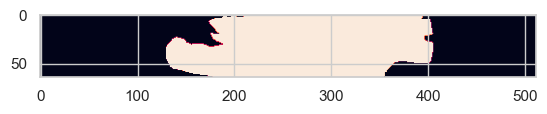

In [58]:
plt.imshow(majority_vote['10'])
print(np.unique(majority_vote['10']))

In [59]:
# compute kappa values between majority vote and unet_preds, and bewteen majority vote and ground truth
majority_list = []
for slice_id in slices_ids:
    majority_list.append({'slice_id': slice_id,
                    'Majority': 'majority_vote',
                    'Rater': 'unet_preds',
                    'Kappa': cohen_kappa_score(majority_vote[slice_id].flatten(), 
                                               all_segmentations['unet_preds'][slice_id].flatten())})
    majority_list.append({'slice_id': slice_id,
                    'Majority': 'majority_vote',
                    'Rater': 'ground_truth',
                    'Kappa': cohen_kappa_score(majority_vote[slice_id].flatten(), 
                                               all_segmentations['ground_truth'][slice_id].flatten())})
    
majority_df = pd.DataFrame(majority_list)

In [60]:
majority_df

,slice_id,Majority,Rater,Kappa
0,01,majority_vote,unet_preds,0.385602
1,01,majority_vote,ground_truth,0.244977
2,02,majority_vote,unet_preds,0.064482
3,02,majority_vote,ground_truth,0.330967
4,03,majority_vote,unet_preds,0.486580
5,03,majority_vote,ground_truth,0.063306
6,05,majority_vote,unet_preds,0.334793
7,05,majority_vote,ground_truth,0.130930
8,06,majority_vote,unet_preds,0.038091
9,06,majority_vote,ground_truth,0.047944


Text(0, 0.5, 'Agreement with majority vote (kappa)')

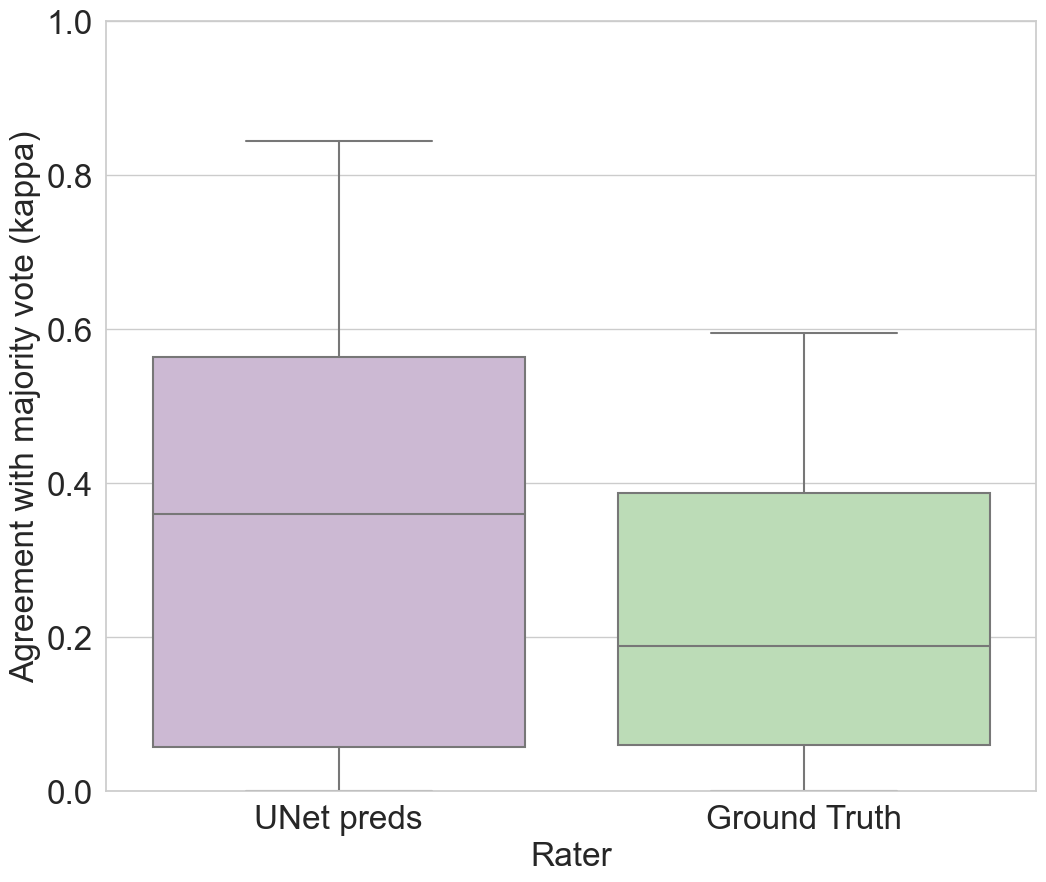

In [61]:
# visualize kappa values for majority vote and visualize if difference is significant
plt.figure(figsize = (12,10))

sns.set_theme(style="whitegrid")
ax = sns.boxplot(x="Rater",
                 y="Kappa",
                 data=majority_df,
                 palette="PRGn")
ax.set_ylim(0, 1)
ax.tick_params(axis='both', which='major', labelsize=24)
ax.set_xticklabels(['UNet preds', 'Ground Truth'], rotation=0)
ax.set_xlabel('Rater', fontsize=24)
ax.set_ylabel('Agreement with majority vote (kappa)', fontsize=24)

In [62]:
# compute statistical significance of kappa values between majority vote and unet_preds versus bewteen majority vote and ground truth
from scipy.stats import ttest_rel, ttest_ind

ttest_rel(majority_df[majority_df['Rater']=='unet_preds']['Kappa'],
            majority_df[majority_df['Rater']=='ground_truth']['Kappa'])

TtestResult(statistic=1.6435170045747263, pvalue=0.14427639737313744, df=7)

In [63]:

ttest_ind(majority_df[majority_df['Rater']=='unet_preds']['Kappa'],
            majority_df[majority_df['Rater']=='ground_truth']['Kappa'])

Ttest_indResult(statistic=0.860407528130848, pvalue=0.4040588447530201)